# Capstone Project: The Battle of Neighborhoods

## Assignment: Where to open a Italian restaurant in Amsterdam


This project is the final assignment of the IBM Professional Data science Certificate. This certificate consists of a series of 9 courses in which data science skills, including Data Science Methodology, data mining and analysis with python has been studied and applied.
The main objectives for this project are the following:

-	leverage location data provided by Foursquare and the Data of Amsterdam website
-	applying data science skills in machine learning and data visualization
-	Segmentation and clustering of location data in order to explore neighborhoods to help addressing a business problem

The results will be presented in this Jupyter Notebook as well as in a presentation and a final report published on Github.


    

### Before we start lets import the libraries needed in this notebook

In [125]:
# importing basic libraries
import pandas as pd # the pandas package
import numpy as np # the numpy package
#!pip install geopandas
import geopandas as gpd
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install folium
import requests # retrieve function used to get the nearby venues
import folium # map rendering library
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules vor data visualisation
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage machinelearning
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## 1. Data acquisition

### Loading the neighborhood data from the  Amsterdam data website

The Amsterdam data website (https://maps.amsterdam.nl) has all the geographical data this project needs. \
The geographical data of the neighborhoods is downloadable in different formats like .csv and Geo Json.
An advantage of the Geo Json format, which is used in this project, is its precise definition of each neighborhood where the borders are defined by a polygon consisting of al the latitudes and longitudes. 




In [126]:
# after downloading the GeoJson file lets import it into a geopandas dataframe and plot the head of the dataframe
path = ("/Users/kwraakie/Desktop/projects/Coursera_Capstone/scripts/Data/geojson.json")
amsterdam_data = gpd.read_file(path)
amsterdam_data.head()


,Buurtcombinatie_code,Buurtcombinatie,Stadsdeel_code,Opp_m2,geometry
0,A00,Burgwallen-Oude Zijde,A,404733,"POLYGON ((4.90326 52.37658, 4.90298 52.37668, ..."
1,A01,Burgwallen-Nieuwe Zijde,A,728412,"POLYGON ((4.90641 52.38003, 4.90601 52.38009, ..."
2,A02,Grachtengordel-West,A,569073,"POLYGON ((4.89401 52.37875, 4.89369 52.37889, ..."
3,A03,Grachtengordel-Zuid,A,641845,"POLYGON ((4.90278 52.36279, 4.90156 52.36515, ..."
4,A04,Nieuwmarkt/Lastage,A,1066820,"POLYGON ((4.91361 52.37259, 4.91359 52.37301, ..."


### If we look closer to the above dataframe we may notice the following

- Column names are in dutch which we want to translate into English
- some columns as Buurtcombinatie_code and Stadsdeel_code don't provide useful information and can be dropped
- de location is provided as a polygon defining precisely the borders of the neighborhoods.
- since the Foursquare API is not supporting this format the polygon has to be transformed into a signle point in order to retrieve venues data.


In [127]:
# removing and renaming columns
amsterdam_data.drop(['Stadsdeel_code','Buurtcombinatie_code','Opp_m2'],axis=1,inplace=True)
amsterdam_data.rename(columns={'Buurtcombinatie': 'Neighborhood'},inplace=True)
amsterdam_data.head(5)

,Neighborhood,geometry
0,Burgwallen-Oude Zijde,"POLYGON ((4.90326 52.37658, 4.90298 52.37668, ..."
1,Burgwallen-Nieuwe Zijde,"POLYGON ((4.90641 52.38003, 4.90601 52.38009, ..."
2,Grachtengordel-West,"POLYGON ((4.89401 52.37875, 4.89369 52.37889, ..."
3,Grachtengordel-Zuid,"POLYGON ((4.90278 52.36279, 4.90156 52.36515, ..."
4,Nieuwmarkt/Lastage,"POLYGON ((4.91361 52.37259, 4.91359 52.37301, ..."


### Transforming Polygon into single point

To be able to perform queries on the foursquare database using the api we need to have a single point defined by longitude and lattitude. 

In [128]:
# Calculation of center of interest
# transform the polygon into a single center of interest by using the weiged average in lon lat.

#calculating Centriod out of polygon
#add columns for centroids lon and lat
amsterdam_data['Longitude'] = 0.0
amsterdam_data['Latitude'] = 0.0
# calculate centroid lon lat for every polygon in the geopandas dataset
for i, Buurtcombinatie_code in enumerate(amsterdam_data.geometry):
    p_list = list(amsterdam_data.exterior[i].coords)
    lon = [x[0] for x in p_list]
    lat = [y[1] for y in p_list]
    count = len(p_list)
    centroid_lat = sum(lat) / count
    centroid_lon = sum(lon) / count
    amsterdam_data.at[i, 'Longitude'] = centroid_lon
    amsterdam_data.at[i, 'Latitude'] = centroid_lat

In [129]:
amsterdam_data.head(100)


,Neighborhood,geometry,Longitude,Latitude
0,Burgwallen-Oude Zijde,"POLYGON ((4.90326 52.37658, 4.90298 52.37668, ...",4.896919,52.372084
1,Burgwallen-Nieuwe Zijde,"POLYGON ((4.90641 52.38003, 4.90601 52.38009, ...",4.895055,52.374195
2,Grachtengordel-West,"POLYGON ((4.89401 52.37875, 4.89369 52.37889, ...",4.887844,52.373349
3,Grachtengordel-Zuid,"POLYGON ((4.90278 52.36279, 4.90156 52.36515, ...",4.892044,52.365930
4,Nieuwmarkt/Lastage,"POLYGON ((4.91361 52.37259, 4.91359 52.37301, ...",4.904592,52.371729
...,...,...,...,...
94,"Bijlmer Oost (E,G,K)","POLYGON ((4.99690 52.31763, 4.99679 52.31775, ...",4.982963,52.324360
95,Nellestein,"POLYGON ((5.01407 52.30423, 5.01354 52.30445, ...",4.999182,52.307183
96,Holendrecht/Reigersbos,"POLYGON ((4.98358 52.29045, 4.98228 52.29061, ...",4.976040,52.293713
97,Gein,"POLYGON ((5.00796 52.30154, 5.00593 52.30154, ...",4.994089,52.296346


### Plotting the map of amsterdam with neighborhoods and calculated centers

Lets visualise the neighborhoods as found in the Geopandas data frame: amsterdam_data

Based on the plot below we can form the following conclusions:

- the size of neighborhood varies as well as their form. 
- Searching for venues in small nehigborhoods of the city center will result in:

a: duplicate venues where the radius will overlap \
b: wrongly assigned because venues because of duplicates and search radius reach outside of the neighborhood

We now have to address these findings and correct the errors



In [130]:
# put into pandas dataframe
import folium    

# Picked location between Sudbury and Somerville:
amsterdam_map = folium.Map(location=[52.379189, 4.899431],zoom_start=12)


folium.GeoJson(amsterdam_data).add_to(amsterdam_map)

# add markers to map
for lat, lng, neighborhood in zip(amsterdam_data['Latitude'], amsterdam_data['Longitude'], amsterdam_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)  

amsterdam_map

## Data mining Foursquare database.

We have a dataframe containing:

- neighborhood names
- polygon feature containing the borders of the neighborhood
- calculateed center of interest for performing Foursquare calls

Lets put this data frame to use and retrieve the venue data in all the neighborhoods


In [7]:
# creating initial variables needed for usage of the API
CLIENT_ID = '*****************************' # your Foursquare ID
CLIENT_SECRET = '****************************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: OHZBOQBJNO2GBYZVBP02NRL5NRZXTK4CSXDFADLDGG2ZTPOX
CLIENT_SECRET:K0VCMG3WZS3TDXBDFWDTQSREUYNM0M3SJRQRNKOGHX3YXXK4


In [8]:
# Create a funtion to search for venues, order the results in columns and deliver a output as a pandas dataframe
    # input parameters are
    # names: name of the neighborhood
    # categoryID: The specific categorie to search for to limit results and filter out unwanted venues
    # latitudes: geograpical location point for search
    # longitudes: geograpical location point for search
    # radius: seach radius predefined as 500

def getNearbyVenues(names,categoryId, latitudes, longitudes, radius=500):
    nr_of_venues = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        #url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            categoryId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'], 
            v['venue']['categories'][0]['id']) for v in results])     
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue',
                  'id',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category',
                  'Venue Category id']
    return(nearby_venues)

## Lets perform the query using the above created function and defined credentials

In [14]:
# perform the query for venues
# we define the folowing string for food of venues ID's containing only the restaurant venues
# for more info see: https://developer.foursquare.com/docs/build-with-foursquare/categories/
food = '503288ae91d4c4b30a586d67,4bf58dd8d48988d1c8941735,4bf58dd8d48988d14e941735,'\
        '4bf58dd8d48988d142941735,4bf58dd8d48988d169941735,52e81612bcbc57f1066b7a01,5e179ee74ae8e90006e9a746,'\
        '52e81612bcbc57f1066b7a02,4bf58dd8d48988d17a941735,4bf58dd8d48988d144941735,5293a7d53cf9994f4e043a45,'\
        '52f2ae52bcbc57f1066b8b81,5744ccdfe4b0c0459246b4d0,4bf58dd8d48988d109941735,52e81612bcbc57f1066b7a05,'\
        '52e81612bcbc57f1066b7a09,4bf58dd8d48988d10c941735,4bf58dd8d48988d10d941735,4c2cd86ed066bed06c3c5209,'\
        '4bf58dd8d48988d10e941735,52e81612bcbc57f1066b79ff,52e81612bcbc57f1066b79fe,52e81612bcbc57f1066b79fa,'\
        '4bf58dd8d48988d10f941735,4bf58dd8d48988d110941735,52e81612bcbc57f1066b79fd,4bf58dd8d48988d1be941735,'\
        '4bf58dd8d48988d1c0941735,4bf58dd8d48988d1c1941735,4bf58dd8d48988d115941735,52e81612bcbc57f1066b79f9,'\
        '4bf58dd8d48988d1c2941735,52e81612bcbc57f1066b79f8,4bf58dd8d48988d1ca941735,52e81612bcbc57f1066b7a04,'\
        '4def73e84765ae376e57713a,4bf58dd8d48988d1c4941735,5293a7563cf9994f4e043a44,4bf58dd8d48988d1c6941735,'\
        '5744ccdde4b0c0459246b4a3,4bf58dd8d48988d1ce941735,56aa371be4b08b9a8d57355a,4bf58dd8d48988d14f941735,'\
        '4bf58dd8d48988d150941735,5413605de4b0ae91d18581a9,4bf58dd8d48988d1cc941735,4bf58dd8d48988d158941735,'\
        '56aa371be4b08b9a8d573538,4f04af1f2fb6e1c99f3db0bb,52e928d0bcbc57f1066b7e96,4bf58dd8d48988d1d3941735'
italian_restaurants = '4bf58dd8d48988d110941735'
arts_Entertainment = '4d4b7104d754a06370d81259'
nightlife = '4d4b7105d754a06376d81259'
travel_Transport = '4d4b7105d754a06379d81259'

# Perform the actual query and add then to a dataframe using function getNearbyVenues

restaurants = getNearbyVenues(names=amsterdam_data['Neighborhood'],categoryId=food,
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude']
                                  )
italian_restaurants = getNearbyVenues(names=amsterdam_data['Neighborhood'],categoryId=italian_restaurants,
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude']
                                  )
arts_Entertainment = getNearbyVenues(names=amsterdam_data['Neighborhood'],categoryId=arts_Entertainment,
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude']
                                  )
nightlife = getNearbyVenues(names=amsterdam_data['Neighborhood'],categoryId=nightlife,
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude']
                                  )
travel_Transport = getNearbyVenues(names=amsterdam_data['Neighborhood'],categoryId=travel_Transport,
                                   latitudes=amsterdam_data['Latitude'],
                                   longitudes=amsterdam_data['Longitude'])

Burgwallen-Oude Zijde
Burgwallen-Nieuwe Zijde
Grachtengordel-West
Grachtengordel-Zuid
Nieuwmarkt/Lastage
Haarlemmerbuurt
Jordaan
De Weteringschans
Weesperbuurt/Plantage
Oostelijke Eilanden/Kadijken
Westelijk Havengebied
Houthavens
Spaarndammer- en Zeeheldenbuurt
Staatsliedenbuurt
Centrale Markt
Frederik Hendrikbuurt
Da Costabuurt
Kinkerbuurt
Van Lennepbuurt
Helmersbuurt
Overtoomse Sluis
Vondelbuurt
Sloterdijk
Landlust
Erasmuspark
De Kolenkit
Geuzenbuurt
Van Galenbuurt
Hoofdweg e.o.
Westindische Buurt
Chassébuurt
Bedrijventerrein Sloterdijk
Slotermeer-Noordoost
Slotermeer-Zuidwest
Geuzenveld
Eendracht
Lutkemeer/Ookmeer
Osdorp-Oost
Osdorp-Midden
De Punt
Middelveldsche Akerpolder
Slotervaart Noord
Overtoomse Veld
Westlandgracht
Sloter-/Riekerpolder
Slotervaart Zuid
Zuidas
Oude Pijp
Nieuwe Pijp
Zuid Pijp
Hoofddorppleinbuurt
Schinkelbuurt
Willemspark
Museumkwartier
Stadionbuurt
Apollobuurt
Scheldebuurt
IJselbuurt
Rijnbuurt
Prinses Irenebuurt e.o.
Buitenveldert-West
Buitenveldert-Oost
Weespe

In [15]:
# safe the data frame to an Excel file for possible later use.
restaurants.to_excel("./Data/restaurants.xlsx",index=False) 
italian_restaurants.to_excel("./Data/italian_restaurants.xlsx",index=False) 
arts_Entertainment.to_excel("./Data/arts_Entertainment.xlsx",index=False) 
nightlife.to_excel("./Data/nightlife.xlsx",index=False) 
travel_Transport.to_excel("./Data/travel_Transport.xlsx",index=False) 

In [169]:
# opening data frames from excel: if needed to reload the data we dont have to perform another query
# but just reload the data from the exported excel files

# loading dataframe from excel file into dataframe
restaurants = pd.read_excel('./Data/restaurants.xlsx')
italian_restaurants = pd.read_excel('./Data/italian_restaurants.xlsx')
arts_Entertainment = pd.read_excel('./Data/arts_Entertainment.xlsx')
nightlife = pd.read_excel('./Data/nightlife.xlsx')
travel_Transport = pd.read_excel('./Data/travel_Transport.xlsx')

In [170]:
#### Let's find out how many unique categories can be found from all the returned venues
print('There are {} uniques categories.'.format(len(restaurants['Venue Category id'].unique())))

There are 97 uniques categories.


# 2. Data cleaning


As mentioned earlier we have to correct the venue data for the following possible errors

- duplicates ( due to search radius and neighborhood size )
- remove unwanted categories: check if only predefined venues are found in the query results
- assigne the venues to the correct neighborhood



### Removing duplicate values

In [133]:
# function: use the method drop_duplicates based on the value name and publish
#    - number of deleted venues
#    - number of remaining venues

def remove_duplicates(venues):
    orig_vcount =venues.shape[0]
    venues.drop_duplicates(subset=['Venue'],inplace=True)
    print('Duplicates removed:',orig_vcount - venues.shape[0],' ||', 'Remaining number of venues:',venues.shape[0])
    return(venues)

# remove the duplicates from the venue dataframes
restaurants = remove_duplicates(restaurants)
italian_restaurants = remove_duplicates(italian_restaurants)
arts_Entertainment = remove_duplicates(arts_Entertainment)
nightlife = remove_duplicates(nightlife)
travel_Transport = remove_duplicates(travel_Transport)

Duplicates removed: 2368  || Remaining number of venues: 1469
Duplicates removed: 883  || Remaining number of venues: 371
Duplicates removed: 832  || Remaining number of venues: 569
Duplicates removed: 1384  || Remaining number of venues: 811
Duplicates removed: 1525  || Remaining number of venues: 1044


### After removing duplicates lets take a look if there is still contamination within the dataset

The data frames restaurants and italian_restaurants are acquired using specific category ID's
lets see if they still contain other venues than "restaurant venues:

In [134]:
# lets find out if the data frame is still contaminated with other categories
rest = restaurants[~restaurants['Venue Category'].str.contains("Restaurant")]
rest.head(14)
rest.groupby(['Venue Category']).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category id
Venue Category,,,,,,,,
Bakery,1,1,1,1,1,1,1,1
Bar,3,3,3,3,3,3,3,3
Bed & Breakfast,2,2,2,2,2,2,2,2
Bistro,1,1,1,1,1,1,1,1
Brasserie,6,6,6,6,6,6,6,6
Burrito Place,1,1,1,1,1,1,1,1
Café,1,1,1,1,1,1,1,1
Chocolate Shop,1,1,1,1,1,1,1,1
Cigkofte Place,1,1,1,1,1,1,1,1


As shown above there are still venues in the dataframe not being a restaurant and we have to remove them...

In [135]:
# define data frame with the venue categories to be excluded

non_competition_venues = {
    "BBQ Joint": "4bf58dd8d48988d1df931735",
    "Bagel Shop": "4bf58dd8d48988d179941735",
    "Bakery": '4bf58dd8d48988d16a941735',
    "Bar": '4bf58dd8d48988d116941735',
    "Breakfast Spot": '4bf58dd8d48988d143941735',
    "Bed & Breakfast": '4bf58dd8d48988d1f8931735',
    "Bubble Tea Shop": '52e81612bcbc57f1066b7a0c',
    "Buffet": '52e81612bcbc57f1066b79f4',
    "Brewery":'50327c8591d4c4b30a586d5d',
    "Burger Joint": '4bf58dd8d48988d16c941735',
    "Cafeteria": '4bf58dd8d48988d128941735',
    "Café": '4bf58dd8d48988d16d941735',
    "Coffee Shop": '4bf58dd8d48988d1e0931735',
    "Cocktail Bar":'4bf58dd8d48988d11e941735',
    "Creperie": '52e81612bcbc57f1066b79f2',
    "Chocolate Shop": '52f2ab2ebcbc57f1066b8b31',
    "Dessert Shop":   '4bf58dd8d48988d1d0941735',
    "Deli / Bodega": '4bf58dd8d48988d146941735',
    "Cupcake Shop": '4bf58dd8d48988d1bc941735',
    "Ice Cream Shop": '4bf58dd8d48988d1c9941735',
    "Frozen Yogurt Shop": '512e7cae91d4cbb4e5efe0af',
    "Fish Market": '4bf58dd8d48988d10e951735',
    "Pastry Shop": '5744ccdfe4b0c0459246b4e2',
    "Pie Shop": '52e81612bcbc57f1066b7a0a',
    "Food & Drink Shop": '4bf58dd8d48988d1f9941735',
    "Donut Shop": '4bf58dd8d48988d148941735',
    "Fast Food Restaurant": '4bf58dd8d48988d16e941735',
    "Fish & Chips Shop": '4edd64a0c7ddd24ca188df1a',
    "Food Stand": '56aa371be4b08b9a8d57350b',
    "Food Truck": '4bf58dd8d48988d1cb941735',
    "Fried Chicken Joint": '4d4ae6fc7a7b7dea34424761',
    "Friterie": '55d25775498e9f6a0816a37a',
    "Gastropub": '4bf58dd8d48988d155941735',
    "Hot Dog Joint": '4bf58dd8d48988d16f941735',
    "Hotel": '4bf58dd8d48988d1fa931735',
    "Irani Cafe": '54135bf5e4b08f3d2429dfe7',
    "Irish Pub": '52e81612bcbc57f1066b7a06',
    "Juice Bar": '4bf58dd8d48988d112941735',
    "Kebab Restaurant": '5283c7b4e4b094cb91ec88d7',
    "Pet Café": '56aa371be4b08b9a8d573508',
    "Poutine Place": '56aa371be4b08b9a8d5734c7',
    "Salad Place": '4bf58dd8d48988d1bd941735',
    "Snack Place": '4bf58dd8d48988d1c7941735',
    "Sandwich Place": '4bf58dd8d48988d1c5941735',
    "Salon / Barbershop": '4bf58dd8d48988d110951735',
    "Tea Room": '4bf58dd8d48988d1dc931735',
    "Truck Stop": '57558b36e4b065ecebd306dd',
    "Wings Joint": '4bf58dd8d48988d14c941735',
    "Wine Bar": ''
}
# turn the dict into a pandas Data Frame
exclusions = pd.DataFrame(non_competition_venues.items(), columns=['Category', 'Search Key'])
exclusions

# We loop over the exclusions data frame and drop every row in the restaurants key containing the seach key.
for index, row in exclusions.iterrows():
    print('Dropping venues with Category id:', row['Search Key'])
    restaurants.drop(restaurants.loc[restaurants['Venue Category id']==row['Search Key']].index, inplace=True)
    italian_restaurants.drop(italian_restaurants.loc[italian_restaurants['Venue Category id']==row['Search Key']].index, inplace=True) 

Dropping venues with Category id: 4bf58dd8d48988d1df931735
Dropping venues with Category id: 4bf58dd8d48988d179941735
Dropping venues with Category id: 4bf58dd8d48988d16a941735
Dropping venues with Category id: 4bf58dd8d48988d116941735
Dropping venues with Category id: 4bf58dd8d48988d143941735
Dropping venues with Category id: 4bf58dd8d48988d1f8931735
Dropping venues with Category id: 52e81612bcbc57f1066b7a0c
Dropping venues with Category id: 52e81612bcbc57f1066b79f4
Dropping venues with Category id: 50327c8591d4c4b30a586d5d
Dropping venues with Category id: 4bf58dd8d48988d16c941735
Dropping venues with Category id: 4bf58dd8d48988d128941735
Dropping venues with Category id: 4bf58dd8d48988d16d941735
Dropping venues with Category id: 4bf58dd8d48988d1e0931735
Dropping venues with Category id: 4bf58dd8d48988d11e941735
Dropping venues with Category id: 52e81612bcbc57f1066b79f2
Dropping venues with Category id: 52f2ab2ebcbc57f1066b8b31
Dropping venues with Category id: 4bf58dd8d48988d1d09417

In [136]:
len(restaurants)
restaurants.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category,Venue Category id
0,Burgwallen-Oude Zijde,52.372084,4.896919,Bridges Restaurant,4b8a4fdaf964a520076832e3,52.370818,4.895087,Seafood Restaurant,4bf58dd8d48988d1ce941735
2,Burgwallen-Oude Zijde,52.372084,4.896919,Eetcafé Bern,4a26ff69f964a520857f1fe3,52.372575,4.900645,Swiss Restaurant,4bf58dd8d48988d158941735
3,Burgwallen-Oude Zijde,52.372084,4.896919,Kaagman & Kortekaas,55e5ff02498e9eb3a234f62c,52.374878,4.892455,French Restaurant,4bf58dd8d48988d10c941735
4,Burgwallen-Oude Zijde,52.372084,4.896919,La Zoccola del Pacioccone,5648c396498edda4852d4c23,52.375297,4.893965,Italian Restaurant,4bf58dd8d48988d110941735
5,Burgwallen-Oude Zijde,52.372084,4.896919,The White Room,5718cbbd498efa35585946b1,52.373178,4.894687,French Restaurant,4bf58dd8d48988d10c941735


In [171]:
# Now the restaurant dataframes are created and cleaned lest see how the venues are assigned by plotting them into the folium map

# create dataframe for Burgwallen-Nieuwe Zijde
# slice only the restaurants with assigned 'Burgwallen-Nieuwe Zijde'
BNZ_rest = restaurants[restaurants.Neighborhood == 'Burgwallen-Nieuwe Zijde']
BNZ_irest = italian_restaurants[italian_restaurants.Neighborhood == 'Burgwallen-Nieuwe Zijde']

# Now plot them in the graph as markers

# put into pandas dataframe
import folium    

# Picked location between Sudbury and Somerville:
amsterdam_map = folium.Map(location=[52.379189, 4.899431],zoom_start=14)


folium.GeoJson(amsterdam_data).add_to(amsterdam_map)

# add restaurants to map
for lat, lng, Venue in zip(BNZ_rest['Venue Latitude'], BNZ_rest['Venue Longitude'], BNZ_rest['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)  

# add italian restaurants to map
for lat, lng, Venue in zip(BNZ_irest['Venue Latitude'], BNZ_irest['Venue Longitude'], BNZ_irest['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)      
    
amsterdam_map

### That is NOT looking good. 

As suspected a circular query on the Foursquare database does not assign the venues well to the correct neighborhoods.
- removing duplicated does not the neighborhood into account and deletes the first duplicates it finds
- as seen above the venues are scattered over the neighborhoods

We clearly need to reassign and check if the situation has been improved

### After cleaning the data we have to make shure the venues are assigned to the correct neighborhood.

Todo so we convert the venue dataframe to a Geopandas dataframe and create a geometry object based on the lat and lon comumns.


In [138]:
Geo_restaurants = gpd.GeoDataFrame(restaurants,geometry=gpd.points_from_xy(restaurants['Venue Longitude'],restaurants['Venue Latitude']))
Geo_italian_restaurants = gpd.GeoDataFrame(italian_restaurants,geometry=gpd.points_from_xy(italian_restaurants['Venue Longitude'],italian_restaurants['Venue Latitude']))
Geo_arts_Entertainment = gpd.GeoDataFrame(arts_Entertainment,geometry=gpd.points_from_xy(arts_Entertainment['Venue Longitude'],arts_Entertainment['Venue Latitude']))
Geo_nightlife = gpd.GeoDataFrame(nightlife,geometry=gpd.points_from_xy(nightlife['Venue Longitude'],nightlife['Venue Latitude']))
Geo_travel_Transport = gpd.GeoDataFrame(travel_Transport,geometry=gpd.points_from_xy(travel_Transport['Venue Longitude'],travel_Transport['Venue Latitude']))

# since we are going to assign the found venues based on the geometry attibute lets removed columns 'Neighborhood', 'Neighborhood Latitude and 'Neighborhood Longitude'
Geo_restaurants.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],axis=1,inplace=True)
Geo_italian_restaurants.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],axis=1,inplace=True)
Geo_arts_Entertainment.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],axis=1,inplace=True)
Geo_nightlife.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],axis=1,inplace=True)
Geo_travel_Transport.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],axis=1,inplace=True)

### Now we have to assigne the found venues to the correct geographical neighborhood

In [139]:
#Creat a function which assigne each neighborhood based on lat and lon data.

#def get_pip (gdf, regions): Vin analysis: venue in neighborhood
def assign_venues (venues, locations):
    n_list = list(locations.Neighborhood)
    print('Number of Neighborhoods:', len(n_list))
    #create empty dataframe
    df = pd.DataFrame().reindex_like(venues).dropna()
    for n in n_list:
        #get neighborhood name from location data
        poly = (locations.loc[locations.Neighborhood==n])
        poly.reset_index(drop = True, inplace = True)
        # find all the venues intersecting with the neighborhood 
        # when venue falls withing the boundaries of the neighborhood assign "true" otherwise "false"
        vin_tf = venues.within(poly.loc[0, 'geometry'])
        #filter venues dataframe keeping only the venues containing a true value
        vin_data = venues.loc[vin_tf].copy()
        #create a new column adding the neighborhood found by the vin analysis
        vin_data['Neighborhood']= n
        vin_data['Longitude']= poly.loc[0, 'Longitude']
        vin_data['Latitude']= poly.loc[0, 'Latitude']
        #append dataframe to main dataframe
        df = df.append(vin_data)

    # perform some quality assurance
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(venues),'\nNew dataframe count=', len(df))
    if df.loc[df.id.duplicated() == True].shape[0] > 0:
        print("There are venues with more than one neighborhood assigned")
    #checking all events have a region
    elif venues.loc[~venues.id.isin(df.id)].shape[0] > 0:
        print("Some venues are outside of the defined neighborhoods")
    else:
        print("No discrepancies found!")
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df




In [140]:
# using the assign_venues function lest assign each venue to its correct neighborhood

restaurants = assign_venues(Geo_restaurants, amsterdam_data)
italian_restaurants = assign_venues(Geo_italian_restaurants, amsterdam_data)
arts_Entertainment = assign_venues(Geo_arts_Entertainment, amsterdam_data)
nightlife = assign_venues(Geo_nightlife, amsterdam_data)
travel_Transport = assign_venues(Geo_travel_Transport, amsterdam_data)



Number of Neighborhoods: 99
Original dataframe count= 1431 
New dataframe count= 1430
Some venues are outside of the defined neighborhoods
Number of Neighborhoods: 99
Original dataframe count= 318 
New dataframe count= 318
No discrepancies found!
Number of Neighborhoods: 99
Original dataframe count= 569 
New dataframe count= 561
Some venues are outside of the defined neighborhoods
Number of Neighborhoods: 99
Original dataframe count= 811 
New dataframe count= 807
Some venues are outside of the defined neighborhoods
Number of Neighborhoods: 99
Original dataframe count= 1044 
New dataframe count= 1041
Some venues are outside of the defined neighborhoods


# Ok venue assignment done, now lets evaluate how successful it is.

In [141]:
#create dataframe for Burgwallen-Nieuwe Zijde
# slice only the restaurants with assigned 'Burgwallen-Nieuwe Zijde'
BNZ_rest = restaurants[restaurants.Neighborhood == 'Burgwallen-Nieuwe Zijde']
BNZ_irest = italian_restaurants[italian_restaurants.Neighborhood == 'Burgwallen-Nieuwe Zijde']

# Now plot them in the graph as markers

# put into pandas dataframe
import folium    

# Picked location between Sudbury and Somerville:
amsterdam_map = folium.Map(location=[52.379189, 4.899431],zoom_start=14)


folium.GeoJson(amsterdam_data).add_to(amsterdam_map)

# add restaurants to map
for lat, lng, Venue in zip(BNZ_rest['Venue Latitude'], BNZ_rest['Venue Longitude'], BNZ_rest['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)  

# add italian restaurants to map
for lat, lng, Venue in zip(BNZ_irest['Venue Latitude'], BNZ_irest['Venue Longitude'], BNZ_irest['Venue']):
    label = '{}'.format(Venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)      
    
amsterdam_map

# Plotted restaurants (blue) and Italian restaurants (red)


### Looks good: the found venues for neighborhood 'Burgwallen-Nieuwe Zijde' are all falling within the borders of the neighborhood

## 3. Analyze Each Neighborhood


In [142]:
# create a function for one hot encoding
def one_hot_encode(input_df):

    # one hot encoding
    onehot_df = pd.get_dummies(input_df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot_df['Neighborhood'] = input_df['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    return(onehot_df)


In [143]:
# convert categorical values into numerical using on hot encoding
restaurants_onehot = one_hot_encode(restaurants)
italian_restaurants_onehot = one_hot_encode(italian_restaurants)
arts_Entertainment_onehot = one_hot_encode(arts_Entertainment)
nightlife_onehot = one_hot_encode(nightlife)
travel_Transport_onehot = one_hot_encode(travel_Transport)

And let's examine the new dataframe size.


In [144]:
restaurants_onehot.shape
restaurants_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Bistro,...,Tech Startup,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tree,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Burgwallen-Oude Zijde,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Burgwallen-Oude Zijde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by summing of the frequency of occurrence of each category


In [145]:
restaurants_grouped = restaurants_onehot.groupby('Neighborhood').sum().reset_index()
italian_restaurants_grouped = italian_restaurants_onehot.groupby('Neighborhood').sum().reset_index()
arts_Entertainment_grouped = arts_Entertainment_onehot.groupby('Neighborhood').sum().reset_index()
nightlife_grouped = nightlife_onehot.groupby('Neighborhood').sum().reset_index()
travel_Transport_grouped = travel_Transport_onehot.groupby('Neighborhood').sum().reset_index()
restaurants_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Bistro,...,Tech Startup,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tree,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Amstel III/Bullewijk,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Apollobuurt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Banne Buiksloot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,Bedrijventerrein Sloterdijk,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,"Bijlmer Centrum (D,F,H)",0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,2,0,0,1,0


### we can make a interesting observation from the above!

- we did not get all neighborhoods (95 versus 99) since not all the neighborhoods have to contain venues like restaurants

In [146]:
# Since not all the neighborhoods might contain values we merge the venue data fram with the amsterdam_data dataframe
# Neighborhoods missing in venue data will get an entry containing NaN values, which we will fix later
restaurants_merged = amsterdam_data.merge(restaurants_grouped, how='left', on='Neighborhood')
restaurants_merged = restaurants_merged.drop(['geometry','Longitude','Latitude'],axis=1)
italian_restaurants_merged = amsterdam_data.merge(italian_restaurants_grouped, how='left', on='Neighborhood')
italian_restaurants_merged = italian_restaurants_merged.drop(['geometry','Longitude','Latitude'],axis=1)
arts_Entertainment_merged = amsterdam_data.merge(arts_Entertainment_grouped, how='left', on='Neighborhood')
arts_Entertainment_merged = arts_Entertainment_merged.drop(['geometry','Longitude','Latitude'],axis=1)
nightlife_merged = amsterdam_data.merge(nightlife_grouped, how='left', on='Neighborhood')
nightlife_merged = nightlife_merged.drop(['geometry','Longitude','Latitude'],axis=1)
travel_Transport_merged = amsterdam_data.merge(travel_Transport_grouped, how='left', on='Neighborhood')
travel_Transport_merged = travel_Transport_merged.drop(['geometry','Longitude','Latitude'],axis=1)
restaurants_merged.head()

# changing values NaN to '0' 
restaurants_merged = restaurants_merged.replace(np.NaN, 0)
italian_restaurants_merged = italian_restaurants_merged.replace(np.NaN, 0)
arts_Entertainment_merged = arts_Entertainment_merged.replace(np.NaN, 0)
nightlife_merged = nightlife_merged.replace(np.NaN, 0)
travel_Transport_merged = travel_Transport_merged.replace(np.NaN, 0)

# add a column with the sum of al te venues per neighborhood with name 'Total'
restaurants_merged['Total'] = restaurants_merged.iloc[:, 1:].sum(axis=1)
italian_restaurants_merged['Total'] =italian_restaurants_merged.iloc[:, 1:].sum(axis=1)
arts_Entertainment_merged['Total'] =arts_Entertainment_merged.iloc[:, 1:].sum(axis=1)
nightlife_merged['Total'] = nightlife_merged.iloc[:, 1:].sum(axis=1)
travel_Transport_merged['Total']  =travel_Transport_merged.iloc[:, 1:].sum(axis=1)

restaurants_merged.head(5)

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Bistro,...,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tree,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,Burgwallen-Oude Zijde,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,44.0
1,Burgwallen-Nieuwe Zijde,0.0,0.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0
2,Grachtengordel-West,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,29.0
3,Grachtengordel-Zuid,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,39.0
4,Nieuwmarkt/Lastage,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0


In [147]:
# Take the total of venues per category and Neighborhood into a new dataframe

amsterdam_results = pd.DataFrame()
amsterdam_results['Neighborhood'] = amsterdam_data['Neighborhood']
amsterdam_results['Longitude'] = amsterdam_data['Longitude']
amsterdam_results['Latitude'] = amsterdam_data['Latitude']
amsterdam_results['Restaurants'] = restaurants_merged['Total']
amsterdam_results['Italian restaurants'] =italian_restaurants_merged['Total']
amsterdam_results['Arts\entertainment'] = arts_Entertainment_merged['Total']
amsterdam_results['Nightlife venues'] =nightlife_merged['Total']
amsterdam_results['Trasport venues'] =travel_Transport_merged['Total']

amsterdam_results.head(99)


,Neighborhood,Longitude,Latitude,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
0,Burgwallen-Oude Zijde,4.896919,52.372084,44.0,23.0,29.0,64.0,28.0
1,Burgwallen-Nieuwe Zijde,4.895055,52.374195,69.0,37.0,17.0,46.0,81.0
2,Grachtengordel-West,4.887844,52.373349,29.0,8.0,13.0,23.0,32.0
3,Grachtengordel-Zuid,4.892044,52.365930,39.0,29.0,31.0,35.0,27.0
4,Nieuwmarkt/Lastage,4.904592,52.371729,31.0,11.0,14.0,16.0,33.0
...,...,...,...,...,...,...,...,...
94,"Bijlmer Oost (E,G,K)",4.982963,52.324360,4.0,0.0,3.0,4.0,2.0
95,Nellestein,4.999182,52.307183,1.0,0.0,4.0,0.0,5.0
96,Holendrecht/Reigersbos,4.976040,52.293713,5.0,1.0,3.0,2.0,4.0
97,Gein,4.994089,52.296346,1.0,0.0,0.0,1.0,4.0


## 4. Cluster Neighborhoods


When using k-means clustering on of the important questions to aske: what shoul dbe the value for k.
Using multiple runs fr different values of k. we use the 'elbow method' to determin optimal value of k.

We can use the method Inertia which gives the sum of squared distances of the datapoints to their closest cluster center

In [148]:
# Normalization

# normalizing the data: maak normalizatie in orde!!!!!!
#import pandas as pd
from sklearn import preprocessing

x = amsterdam_results[['Restaurants','Italian restaurants','Arts\entertainment','Nightlife venues','Trasport venues']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm = pd.DataFrame(x_scaled)
norm.head()

,0,1,2,3,4
0,0.523810,0.621622,0.690476,1.000000,0.345679
1,0.821429,1.000000,0.404762,0.718750,1.000000
2,0.345238,0.216216,0.309524,0.359375,0.395062
3,0.464286,0.783784,0.738095,0.546875,0.333333
4,0.369048,0.297297,0.333333,0.250000,0.407407


In [149]:
amsterdam_grouped_clustering = norm
distortions = []
inertias = []
mapping1 = []
mapping2 = []
sil_test = []
labels = []
k_value = range(2,10)
for n in k_value:
    TOR_clustered = KMeans(n_clusters=n, random_state=0).fit(amsterdam_grouped_clustering)
    #Elbow method
    distortion_value =(sum(np.min(cdist(amsterdam_grouped_clustering, TOR_clustered.cluster_centers_, 'euclidean'),axis=1))/amsterdam_grouped_clustering.shape[0])
    distortions.append(distortion_value) 
    inertias.append(TOR_clustered.inertia_) 
  
    #Silhouette test
    labels = TOR_clustered.labels_
    sil_test.append(silhouette_score(amsterdam_grouped_clustering,labels,metric = 'euclidean'))


        

In [150]:
amsterdam_grouped_clustering.head()

,0,1,2,3,4
0,0.523810,0.621622,0.690476,1.000000,0.345679
1,0.821429,1.000000,0.404762,0.718750,1.000000
2,0.345238,0.216216,0.309524,0.359375,0.395062
3,0.464286,0.783784,0.738095,0.546875,0.333333
4,0.369048,0.297297,0.333333,0.250000,0.407407


### After running the k-means clustering for a range of k, we now visualise the performance metrics for elbow method and silhouette score to choose the optimal value of k

- elbow method : wide used as apprach for finding optimal number of k.
- Silhouette method: The Silhouette method measures how similar a datapoint is to its own cluster. The optimal value should be the higest value in the rance +1 and -1

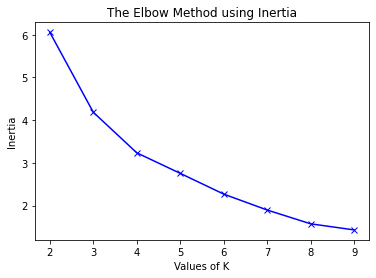

In [151]:
#Elbow score
plt.plot(k_value, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

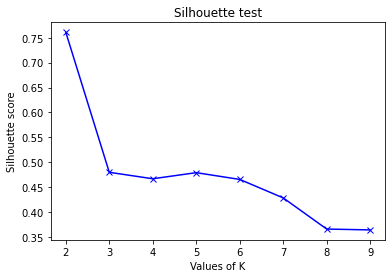

In [152]:
### Silhouette score
plt.plot(k_value, sil_test, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette test')
plt.show()


Result: As shown above, the elbow graph shows a slight elbow point at k=5 and if we look at the silhouette graph we see that k=5 produces the local highest score. Therefor we choose K=5 to perform the final k-means clustering.


In [154]:
# Clustering the data using value k=5

kclusters = 5

kmeans=[]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,).fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
kmeans.labels_
#len(kmeans.labels_)

array([1, 1, 4, 1, 4, 0, 2, 1, 4, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 2, 0, 3, 0, 3, 0, 4, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3,
       0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 4, 0, 3, 3, 3, 3, 3], dtype=int32)

Now we add the cluster number to the


In [155]:
# add adding Neighborhood Longitude and Latitude back to the dataframe and correct column labels

amsterdam_results.insert(0, 'Cluster Labels', kmeans.labels_)
amsterdam_merged = amsterdam_data
#
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#amsterdam_merged = amsterdam_merged.join(amsterdam_results.set_index('Neighborhood'), on='Neighborhood')

#amsterdam_merged['Cluster Labels'].astype(int)
#amsterdam_merged.head() # check the last columns!
#neighborhoods_venues_sorted.head()
amsterdam_results.head()

,Cluster Labels,Neighborhood,Longitude,Latitude,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
0,1,Burgwallen-Oude Zijde,4.896919,52.372084,44.0,23.0,29.0,64.0,28.0
1,1,Burgwallen-Nieuwe Zijde,4.895055,52.374195,69.0,37.0,17.0,46.0,81.0
2,4,Grachtengordel-West,4.887844,52.373349,29.0,8.0,13.0,23.0,32.0
3,1,Grachtengordel-Zuid,4.892044,52.365930,39.0,29.0,31.0,35.0,27.0
4,4,Nieuwmarkt/Lastage,4.904592,52.371729,31.0,11.0,14.0,16.0,33.0


In [156]:
## Visualise the clustering using Folium

In [165]:
# create map
map_clusters = folium.Map(location=[52.379189, 4.899431],zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add neighborhood borders
folium.GeoJson(amsterdam_data).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_results['Latitude'], amsterdam_results['Longitude'], amsterdam_results['Neighborhood'], amsterdam_results['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster +1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

## Finally lets print the individual clusters for further inspection

## Cluster 1

In [180]:
# display cluster 1 
cluster_1 = amsterdam_results.loc[amsterdam_results['Cluster Labels'] == 0, amsterdam_results.columns[[1] + list(range(4, amsterdam_results.shape[1]))]]

In [181]:
# number of neighborhoods in the cluster
len(cluster_1)

25

In [182]:
cluster_1

,Neighborhood,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
5,Haarlemmerbuurt,30.0,3.0,6.0,16.0,18.0
9,Oostelijke Eilanden/Kadijken,25.0,4.0,7.0,13.0,17.0
12,Spaarndammer- en Zeeheldenbuurt,31.0,4.0,10.0,19.0,8.0
13,Staatsliedenbuurt,18.0,6.0,2.0,8.0,8.0
15,Frederik Hendrikbuurt,15.0,2.0,0.0,8.0,10.0
16,Da Costabuurt,31.0,8.0,0.0,7.0,7.0
17,Kinkerbuurt,36.0,4.0,4.0,11.0,9.0
19,Helmersbuurt,24.0,3.0,4.0,8.0,21.0
20,Overtoomse Sluis,30.0,4.0,1.0,13.0,8.0
21,Vondelbuurt,12.0,3.0,5.0,6.0,23.0


## Cluster 2

In [159]:
# display cluster 2 
amsterdam_results.loc[amsterdam_results['Cluster Labels'] == 1, amsterdam_results.columns[[1] + list(range(4, amsterdam_results.shape[1]))]]

,Neighborhood,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
0,Burgwallen-Oude Zijde,44.0,23.0,29.0,64.0,28.0
1,Burgwallen-Nieuwe Zijde,69.0,37.0,17.0,46.0,81.0
3,Grachtengordel-Zuid,39.0,29.0,31.0,35.0,27.0
7,De Weteringschans,56.0,28.0,33.0,64.0,50.0


## Cluster 3

In [160]:
# display cluster 3 
amsterdam_results.loc[amsterdam_results['Cluster Labels'] == 2, amsterdam_results.columns[[1] + list(range(4, amsterdam_results.shape[1]))]]

,Neighborhood,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
6,Jordaan,84.0,22.0,20.0,47.0,31.0
47,Oude Pijp,76.0,13.0,7.0,50.0,26.0


## Cluster 4

In [161]:
# display cluster 4 
amsterdam_results.loc[amsterdam_results['Cluster Labels'] == 3, amsterdam_results.columns[[1] + list(range(4, amsterdam_results.shape[1]))]]

,Neighborhood,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
10,Westelijk Havengebied,3.0,0.0,3.0,2.0,2.0
11,Houthavens,3.0,0.0,1.0,2.0,10.0
14,Centrale Markt,2.0,0.0,1.0,4.0,4.0
18,Van Lennepbuurt,12.0,1.0,4.0,6.0,4.0
22,Sloterdijk,1.0,0.0,2.0,5.0,7.0
...,...,...,...,...,...,...
94,"Bijlmer Oost (E,G,K)",4.0,0.0,3.0,4.0,2.0
95,Nellestein,1.0,0.0,4.0,0.0,5.0
96,Holendrecht/Reigersbos,5.0,1.0,3.0,2.0,4.0
97,Gein,1.0,0.0,0.0,1.0,4.0


## Cluster 5

In [162]:
# display cluster 5 
amsterdam_results.loc[amsterdam_results['Cluster Labels'] == 4, amsterdam_results.columns[[1] + list(range(4, amsterdam_results.shape[1]))]]

,Neighborhood,Restaurants,Italian restaurants,Arts\entertainment,Nightlife venues,Trasport venues
2,Grachtengordel-West,29.0,8.0,13.0,23.0,32.0
4,Nieuwmarkt/Lastage,31.0,11.0,14.0,16.0,33.0
8,Weesperbuurt/Plantage,27.0,7.0,42.0,14.0,33.0
53,Museumkwartier,50.0,11.0,27.0,21.0,49.0
88,Noordelijke IJ-oevers West,17.0,0.0,15.0,11.0,23.0
92,Amstel III/Bullewijk,17.0,0.0,23.0,20.0,6.0


# Conclusion

### lets review the found 5 clusters and their opportunities.

### Cluster 1

These are neighborhoods mainly located outside of the touristic citycenter. and therefore less interesting for starting a restaurant for tourist and dayvisitors.

Best reachable are: Vondelbuurt and Zuidas which have relatively good transport possibilities and low number of italian restaurants.

#### Could be a good fit for starting a restaurant for locals


### Cluster 2

The most popular neighborhoods of the city. Plenty entertainment venues and fairly saturated with restaurants!

####  Hard areas to start new business and therefore not advisable

### Cluster 3

Very Hip and popular neighbordhoods, reachability outstanding and a lot to do in sens of Culture and Nightlive.
Unfortunately crowded with restaurants as well as plenty Italian restaurants

####  Hard areas to start new business and therefore not advisable

### Cluster 4

Neighborhoods outside of the city center and low reachability by public transport.
Low restaurant coutn but unfortunately also low curltural and nightlife

####  Unpopular areas for going out, therefore not advisable

### Cluster 5

Most intersting cluster. All in balance since located close to city center good transport with public transport and
many cultural venues and options for night life.

Most interesting neighborhoods are: Museum kwartier and Weesper buurt


####  Popular areas with a good restaurant \ italian restaurant ratio. Transportability is good and due to the many cultural venues and nighlife oportunities to start a business